## Plot variant-effect prediction profile and observed SNV positions for windows with varying degrees of predicted constraint

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

FILENAME_PREFIX = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset' 

from numpy import linalg as LA
import pandas as pd 
import numpy as np 

import pysam 

import sys 
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

from read_model import read_model
from bases import BASES 

MCHALE_MODEL = read_model(f"{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-3.trainSet-noncoding.json")

In [117]:
def compute_heat_map(window, embeddings): 
  chromosome = window['chromosome']
  start = int(window['start'])
  end = int(window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    # "fetch" API: https://pysam.readthedocs.io/en/latest/api.html?highlight=fasta#pysam.FastaFile
    # Note that fetch(region=region) does not work if the coordinates in "region" contains commas
    # Workaround is to parse "region" into "chromosome", "start", "end": 
    sequence = genome.fetch(chromosome, start, end)    
    sequence = sequence.upper()
    sequence = sequence[:20] # TODO: remove 

  distances_for_all_sites = []
  mask = np.ones((len(BASES), len(sequence)))
  for site_index, REF in enumerate(sequence): 
    REF_index = BASES.index(REF)
    mask[REF_index, site_index] = 0
    REF_embedding = embeddings[REF_index, site_index]
    distances_for_site = []
    for allele_index in range(len(BASES)): 
      embedding = embeddings[allele_index, site_index]
      delta = REF_embedding - embedding

      # section A.5.2 of https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2
      # details metrics that could be used to quantify distance between embeddings: 
      #    (i) the L1 distance (Manhattan), 
      #    (ii) the L2 distance (Euclidean), 
      #    (iii) the cosine similarity 
      #    (iv) the dot-product (not normalized cosine similarity) 
      distance = LA.norm(delta, 2) 

      distances_for_site.append(distance)
    distances_for_all_sites.append(distances_for_site)
  distances_for_all_sites = np.array(distances_for_all_sites)
  heat_map = distances_for_all_sites.T 

  return heat_map, mask # both indexed as BASES X [site1, site2, ...]

def compute_heat_map_wrapper(window_index): 
  window = pd.read_pickle(f'{FILENAME_PREFIX}.{window_index}.pkl')  
  embeddings = np.load(f'{FILENAME_PREFIX}.{window_index}.npy')
  return compute_heat_map(window, embeddings)

compute_heat_map_wrapper(window_index=0)

(array([[56.481552,  0.      , 54.38895 ,  0.      ,  0.      , 45.581257,
          0.      , 39.20425 , 69.359764,  0.      ,  0.      ,  0.      ,
         41.66563 ,  0.      ,  0.      , 42.90163 , 57.342693,  0.      ,
         42.758816, 48.528767],
        [ 0.      , 65.587105, 48.033203, 80.11393 , 45.87892 ,  0.      ,
         71.34377 , 49.28923 , 57.102943, 49.554356, 43.955856, 50.221573,
         43.632717, 47.883022, 51.55526 ,  0.      ,  0.      , 40.516438,
         35.42658 ,  0.      ],
        [45.61755 , 41.731045,  0.      , 60.679176, 46.8874  , 56.605255,
         60.52949 , 50.694374, 57.516163, 55.652664, 40.751183, 40.787537,
          0.      , 42.930824, 47.14963 , 38.987408, 63.83351 , 57.153492,
          0.      , 33.930153],
        [49.853977, 49.757755, 47.099697, 51.287037, 62.84892 , 38.83412 ,
         60.972507,  0.      ,  0.      , 54.210064, 44.457275, 42.880127,
         40.09198 , 38.40475 , 52.397575, 35.603226, 77.922775, 67.99948 ,
    

In [49]:
from pack_unpack import pack
from snvs import fetch_SNVs
from colorize import print_json

def get_snvs(window): 
  with pysam.TabixFile(MCHALE_MODEL['mutations']) as mutations, pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    SNVs = fetch_SNVs(
      mutations, 
      genome, 
      region=pack(window['chromosome'], window['start'], window['end']),
      meta=MCHALE_MODEL, 
      number_chromosomes_min=MCHALE_MODEL['numberChromosomesMin']
    )
  return [
    {
      **SNV,
      'position_offset': SNV['position'] - window['start']
    }
    for SNV in SNVs
  ]

def get_snvs_wrapper(window_index): 
  window = pd.read_pickle(f'{FILENAME_PREFIX}.{window_index}.pkl')  
  return get_snvs(window)

print_json(get_snvs_wrapper(window_index=0))

[
  {
    "chromosome": "chr8",
    "position": 100862000,
    "REF": "C",
    "ALT": "T",
    "number_ALT_chromosomes": 2,
    "number_chromosomes": 152236,
    "kmer": "ACA",
    "position_offset": 0
  },
  {
    "chromosome": "chr8",
    "position": 100862004,
    "REF": "A",
    "ALT": "G",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152228,
    "kmer": "AAC",
    "position_offset": 4
  },
  {
    "chromosome": "chr8",
    "position": 100862007,
    "REF": "T",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152184,
    "kmer": "ATT",
    "position_offset": 7
  },
  {
    "chromosome": "chr8",
    "position": 100862012,
    "REF": "G",
    "ALT": "A",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152230,
    "kmer": "AGA",
    "position_offset": 12
  },
  {
    "chromosome": "chr8",
    "position": 100862013,
    "REF": "A",
    "ALT": "G",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152248,
    "kmer": "GAA",
  

zscore quantile: 0.0 - 0.005


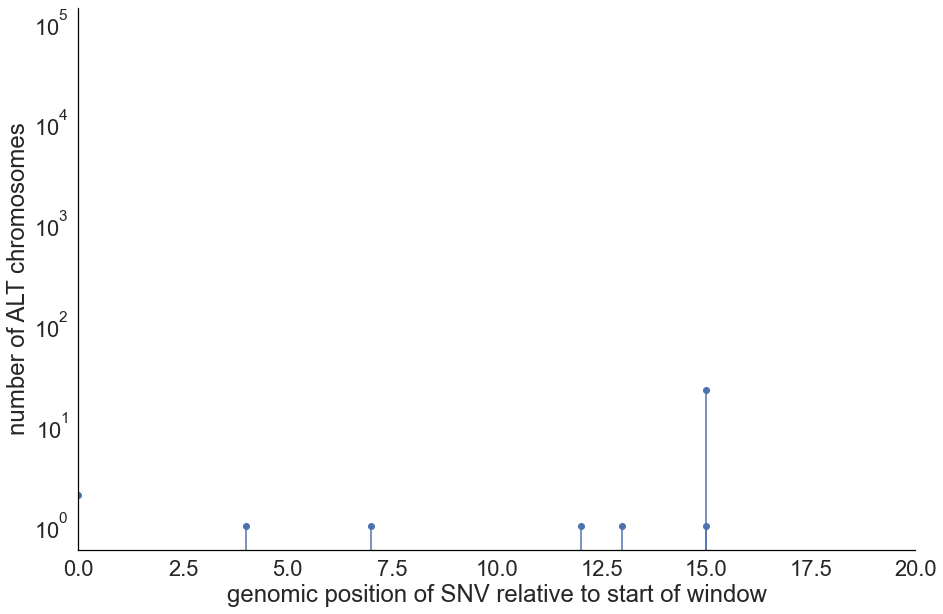

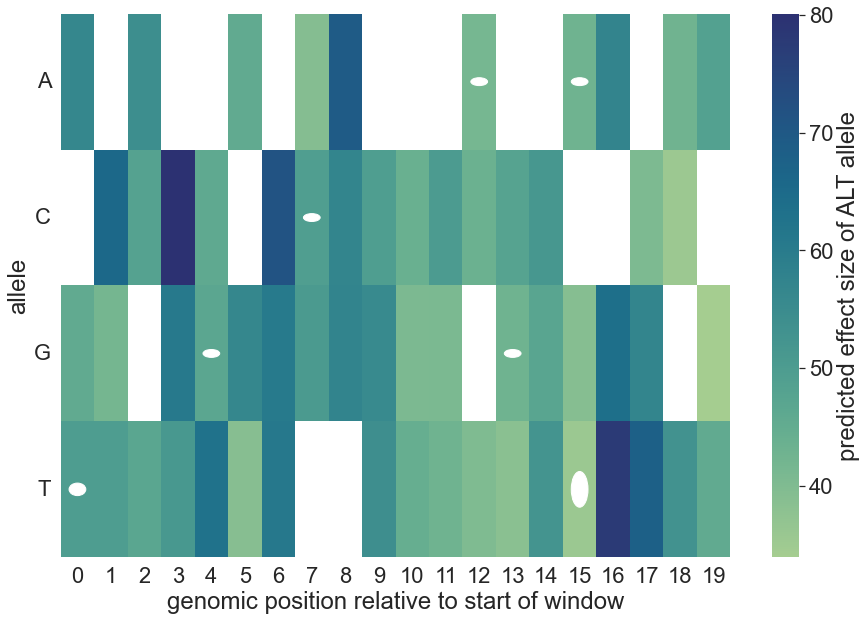

In [147]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

plt.rcParams.update({
  'figure.figsize': (15, 10),
  'axes.facecolor': 'white'
})

from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

def plot_stem(SNVs, linefmt, markerfmt): 
  x = [SNV['position_offset'] for SNV in SNVs]
  y = [SNV['number_ALT_chromosomes'] for SNV in SNVs]

  plt.stem(x, y, linefmt=linefmt, markerfmt=markerfmt)
  plt.yscale('log')
  plt.xlim([0, 20]) # TODO: change to [0, 1000]
  plt.gca().spines['bottom'].set_color('black')
  plt.gca().spines['left'].set_color('black')
  plt.xlabel('genomic position of SNV relative to start of window')
  plt.ylabel('number of ALT chromosomes')
  plt.show()

def create_ellipse(SNV): 
  x = SNV['position_offset'] + 0.5
  y = BASES.index(SNV['ALT']) + 0.5
  log_ALT_count_plus_one = np.log10(SNV['number_ALT_chromosomes']+1)
  log_max_ALT_count_plus_one = np.log10(SNV['number_chromosomes']+1)
  return Ellipse(
    (x,y), 
    width=0.5, 
    height=log_ALT_count_plus_one/log_max_ALT_count_plus_one,
    color='white'
  )

def plot_snvs_and_variant_effects(window_index): 
  window = pd.read_pickle(f'{FILENAME_PREFIX}.{window_index}.pkl')  
  embeddings = np.load(f'{FILENAME_PREFIX}.{window_index}.npy')

  print(f"zscore quantile: {window['negative new chen zscore quantile']}") 

  SNVs = get_snvs(window)
  plot_stem(SNVs, linefmt=None, markerfmt=None)
  
  heat_map, mask = compute_heat_map(window, embeddings)

  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
  ax = sns.heatmap(
      heat_map, 
      cmap = sns.color_palette("crest", as_cmap=True), # https://seaborn.pydata.org/tutorial/color_palettes.html
      center = None, 
      annot = False, 
      # fmt = '.3f',
      # linewidths = 1, 
      cbar_kws = {'label': 'predicted effect size of ALT allele'},
      mask = np.logical_not(mask)
  )
  # ax.invert_yaxis()
  plt.yticks(np.arange(len(BASES))+0.5, list(BASES), rotation=0)
  plt.xlabel('genomic position relative to start of window')
  plt.ylabel('allele')

  ellipses = [create_ellipse(SNV) for SNV in SNVs]
  # https://stackoverflow.com/a/71675432 : 
  p = PatchCollection(ellipses, alpha=1, match_original=True)
  ax.add_collection(p)

plot_snvs_and_variant_effects(window_index=0)

## [TODO] Hypothesis test

TODO: older version of test outlined in 2a at: https://docs.google.com/presentation/d/1naB2zEBWXLoQOP9ioMDe77FlP8dhb63Eu8P_G6Jdpac/edit#slide=id.g22afc145c47_0_8

(4, 20)
(4, 20)


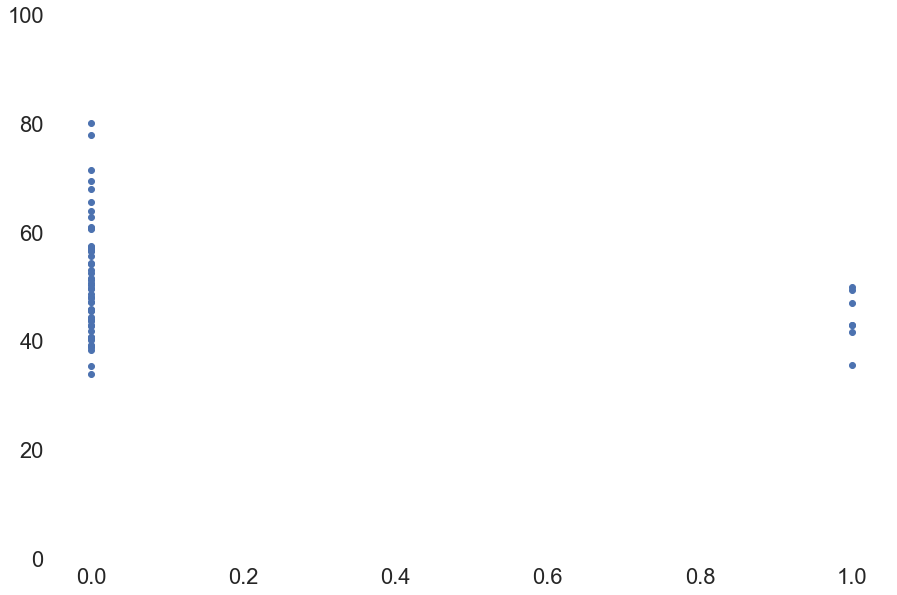

In [180]:
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

from ravel_unravel import ravel

def correlate_snvs_and_variant_effects(window_index): 
  window = pd.read_pickle(f'{FILENAME_PREFIX}.{window_index}.pkl')  
  SNVs = get_snvs(window)
  number_sites = int(window['end']) - int(window['start'])
  SNV_present = np.zeros(shape=(len(BASES), number_sites))
  for SNV in SNVs: 
    site_index = SNV['position_offset']
    if site_index >= number_sites: continue
    ALT_index = BASES.index(SNV['ALT'])
    SNV_present[ALT_index, site_index] = 1 
  SNV_present = SNV_present[:,:20] # TODO: remove 

  embeddings = np.load(f'{FILENAME_PREFIX}.{window_index}.npy')
  heat_map, mask = compute_heat_map(window, embeddings)

  SNV_present = ravel(SNV_present)
  heat_map = ravel(heat_map)
  mask = ravel(mask)

  mask = np.array(mask, dtype=bool)
  ALT_effect_size = heat_map[mask]
  ALT_exists_in_cohort = SNV_present[mask]

  plt.scatter(ALT_exists_in_cohort, ALT_effect_size)
  plt.ylim([0, 100])

  # TODO: 
  # 1. label axes
  # 2. compute and return correlation coefficient 

correlate_snvs_and_variant_effects(window_index=0)

In [ ]:
# TODO: 
# 4. compute X-Y correlation for each zscore quantile 

## [Other resources] Get attention maps
Here is an example on how to retrieve attention maps at a specific layer for a given head and how to plot them.

In [ ]:
print(outs["attention_map_layer_1_number_4"].shape)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns 

sns.set_theme(
    font_scale=2,
    rc={'figure.figsize': (16, 6)}
)

# plot attention maps
fig, axes = plt.subplots(nrows=1, ncols=2)

seq_length0, seq_length1 = int(sequences_lengths[0]), int(sequences_lengths[1])

# plot for first seq in the batch
im0 = axes[0].imshow(
    outs["attention_map_layer_1_number_4"][
        0, 1:(seq_length0 + 1), 1:(seq_length0 + 1)
    ]
)
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
tokens0 = tokens_str[0][1 : (seq_length0 + 1)]
axes[0].set_xticks(list(range(seq_length0)))
axes[0].set_xticklabels(tokens0, rotation=45)
axes[0].set_yticks(list(range(seq_length0)))
axes[0].set_yticklabels(tokens0, rotation=45)
axes[0].grid(False)
fig.colorbar(im0, cax=cax0, orientation="vertical")

# plot for second seq in the batch
im1 = axes[1].imshow(
    outs["attention_map_layer_1_number_4"][
        1, 1:(seq_length1 + 1), 1:(seq_length1 + 1)
    ]
)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
tokens1 = tokens_str[1][1 : (seq_length1 + 1)]
axes[1].set_xticks(list(range(seq_length1)))
axes[1].set_xticklabels(tokens1, rotation=45)
axes[1].set_yticks(list(range(seq_length1)))
axes[1].set_yticklabels(tokens1, rotation=45)
axes[1].grid(False)
fig.colorbar(im1, cax=cax1, orientation="vertical")

fig.tight_layout()

## [Other resources] Get probabilities
Finally, let's look at the model probabilities over the vocabulary at each position. These can be used to compute reconstruction accuracies and perplexities.

In [ ]:
logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    print(probas.shape)
    probabilities.append(probas)

Let's look in particular at a given sequence and position and show the top-k probabilities and corresponding tokens.

In [ ]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 5
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")